# Continuous Control with DDPG

In this notebook I will solve the Unity ML [Reacher Environment](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#reacher) using [Deep Deterministic Policy Gradient](http://proceedings.mlr.press/v32/silver14.pdf) (DDPG). See the [README](https://github.com/bobflagg/Continuous-Control/blob/master/README.md) for instructions on how to setup your environment to run the code here.

In the reacher environment for the Continuous Control Project a double-jointed arm can move to target locations. A reward of +0.1 is provided for each step that the agent's hand is in the goal location. Thus, the goal of the agent is to maintain its position at the target location for as many time steps as possible.
The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector should be a number between -1 and 1.
The task is episodic, and in order to solve the environment, an agent must get an average score of +30 over 100 consecutive episodes.

I’ll solve the distributed version of the task which contains 20 identical agents, each with its own copy of the environment.  My solution borrows code from the [course solution](https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-bipedal) to the [BipedalWalker-v2 Gym Environment](https://gym.openai.com/envs/BipedalWalker-v2/).

## Background

The [Unity ML Reacher](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#reacher) is a *sequential decision making problem*, in which an agent interacts with an environment over discrete time steps and tries to find a policy to maximize the expected discounted return:
$$G_t = \sum_{\tau=t}^{\infty}\gamma^{\tau-t}R_\tau,$$
where $\gamma\in [0, 1]$ is a discount factor that trades-off the importance of immediate and future rewards. See [Sutton and Barto](http://incompleteideas.net/book/the-book.html) for a general discussion of this sort of problem.

In this notebook I'll focus on policy-based methods, which try to directly find an optimal policy, $\pi^*$, that an agent can use to decide what actions to take.  The particular algorithm, 
[Deep Deterministic Policy Gradient](http://proceedings.mlr.press/v32/silver14.pdf) (DDPG), is motivated by an important connection between the action selected by an optimal policy and the ***optimal action-value function***:
	$$Q^*(s, a) =  \max_{\pi}Q^{\pi}(s,a).$$
Namely, if you know the optimal action-value function, then in any given state, $s$, an optimal action can be found by solving
	 $$\pi^*(s) = \arg\max_a Q^*(s,a).$$
DDPG concurrently learns an approximator to $Q^*(s,a)$ and an approximator to $\pi^*(s)$, and it does so in a way which is specifically adapted for environments with continuous action spaces. 

### Learning $Q^*(s,a)$

The starting point for approximating $Q^*(s, a)$  is the **Bellman Equation**:
$$Q^{*}(s,a) = \mathbb{E}\big[R_{t+1}+\gamma\cdot\max_{a'}Q^{*}(S_{t+1},a')| S_t = s, A_t=a\big].$$
Suppose we are approximating $Q^*(s, a)$ with a neural network, $Q_\phi(s,a)$, and we have collected a set $\mathcal{D}$ of
transitions $(s, a, r, s', d)$, then the **mean-squared Bellman error** (MSBE)
		$$L(\phi, \mathcal{D}) = \mathbb{E}_{\mathcal{D}}\big[\big(Q_\phi(s,a)-(r+\gamma\cdot(1-d)\max_{a'}Q_\phi(s',a'))\big)^2\big]$$
tells us roughly how closely $Q_{\phi}$ comes to satisfying the Bellman equation and so can serve as the loss function in tuning $\phi$.

### Learning $\pi^*(s)$

Learning the optimal policy is pretty simple: we want to learn a deterministic policy $\pi^*(s)$ which gives the action that maximizes $Q^*(s, a)$.  This suggests using the loss function
    $$L(\theta, \mathcal{D}) = -\mathbb{E}_{\mathcal{D}}\big[Q_\phi(s,\pi_\theta(s))\big]$$
to tune the parameters, $\theta$, for a neural network, $\pi_\theta(s)$ approximating $\pi^*(s)$.


## Deep Deterministic Policy Gradient for Unity ML Reacher


### The Actor Network

In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from util import hidden_init

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc_units (int): Number of nodes in the hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units)
        self.bn1 = nn.BatchNorm1d(fc_units)
        self.fc2 = nn.Linear(fc_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.bn1(self.fc1(state)))
        return F.tanh(self.fc2(x))

### The Critic Network

In [2]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=256, fc3_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.bns1 = nn.BatchNorm1d(fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.leaky_relu(self.bns1(self.fcs1(state)))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return self.fc4(x)

### The Agent

To get DDPG to learn in a multi-agent environment I had to separate updating network parameters from adding samples to the replay buffer so that I could interleave these two steps in an appropriate proportion.

In [3]:
from collections import namedtuple, deque
import copy
import numpy as np
import torch.optim as optim
import random
from util import OUNoise, ReplayBuffer

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad(): action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise: action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def add(self, state, action, reward, next_state, done):
        """Save experience in replay memory."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

    def update(self):
        """Use random sample from buffer to learn."""
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        #torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)   
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## The Environment

In [4]:
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name='./Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### Training

By separating the updating of network parameters from adding samples to the replay buffer I can interleave these two steps in an appropriate proportion. The hyperparameters UPDATE_EVERY and N_UPDATES determine the proportion: the networks are updated N_UPDATES times after every UPDATE_EVERY timesteps.

In [7]:
UPDATE_EVERY = 20
N_UPDATES = 15

def ddpg(env, agent, n_episodes=150, max_t=925, print_every=100):
    best_average_score = 0.0
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        score = 0
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            score += np.mean(rewards)
            one_done = False
            for i in range(states.shape[0]):
                state, action, reward, next_state, done = states[i], actions[i], rewards[i], next_states[i], dones[i]
                agent.add(state, action, reward, next_state, done)
                if done: one_done = True
            if t % UPDATE_EVERY == 0:
                for j in range(N_UPDATES): agent.update()
            states = next_states
            if one_done: break 
        scores_deque.append(score)
        scores.append(score)
        average_score = np.mean(scores_deque)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_score), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_score))
        if average_score > best_average_score and i_episode > 100:
            best_average_score = average_score
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
    return scores

In [8]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=7654) # 3461 --> 30.67, 4368 --> 32.22
scores = ddpg(env, agent)

Episode 100	Average Score: 24.23
Episode 150	Average Score: 34.26

After 150 episodes the average score is 34.26 which is good enough to solve this task!  Below I show a plot of the scores for the entire training run.

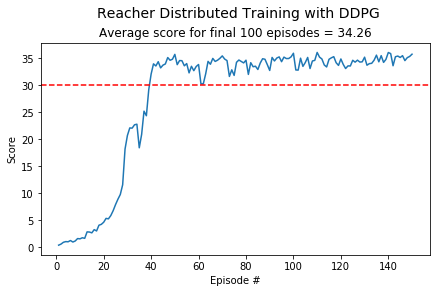

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
ax.axhline(y=30, color='r', linestyle="dashed")
ax.set_title('Average score for final 100 episodes = %0.2f' % np.mean(scores[-100:]))
fig.suptitle('        Reacher Distributed Training with DDPG', fontsize=14)
plt.show()

## Watch a Smart Agent!

In [ ]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name] 
states = env_info.vector_observations
score = np.zeros(num_agents)
while True:
    actions = agent.act(states)
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    score += np.mean(rewards)
    states = next_states
    for i in range(states.shape[0]):
        if dones[i]: break
print('Total score (averaged over agents) this episode: {}'.format(score))
env.close()